In [40]:
TRAIN_SIZE = 320  #544
CROP = 320   #512f

from torchvision.transforms import functional as TF
from torchvision.transforms import InterpolationMode as IM
import torch, numpy as np
from PIL import Image

# Use the same sizes you used for val/test
INF_SIZE = TRAIN_SIZE   # e.g., 320
INF_CROP = CROP         # e.g., 288

def inference_transform(pil_img):
    # resize, optional center-crop, to tensor, normalize
    img = pil_img.convert("RGB")
    img = TF.resize(img, INF_SIZE, interpolation=IM.BILINEAR)
    if INF_CROP and INF_CROP < INF_SIZE:
        img = TF.center_crop(img, INF_CROP)
    img = TF.to_tensor(img)
    img = TF.normalize(img, mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    return img


In [41]:
import torch
import numpy as np
from PIL import Image
import os

# >>>> EDIT THESE to match CoralScapes label IDs <<<<
# Example placeholders:
#  - 0: background/water
#  - 1: healthy coral
#  - 2: bleached/diseased coral
#  - 3: algae
#  - 4: sand/rubble
# Total reef pixels (benthos on the reef, incl. coral states, algae-overgrown, rubble, sponges/anemones)
coral_ids = {
    3, 4, 6, 10, 16, 17, 18, 19, 20, 21, 22, 23,
    25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37
}

# Healthy (live coral only)
healthy_ids = {
    6, 17, 21, 22, 25, 27, 28, 31, 34, 36
}

# # Optional: a simple color map for visualization (extend as needed)
# PALETTE = {
#     0: (0, 0, 0),        # background - black
#     1: (0, 200, 0),      # healthy coral - green
#     2: (255, 255, 0),    # unhealthy coral - yellow
#     3: (0, 0, 255),      # algae - blue
#     4: (200, 150, 100),  # sand - tan
# }

@torch.no_grad()
def predict_image(
    image_input,                      # path or PIL.Image
    model,
    num_classes,
    # save_mask_path=None,
    #ave_overlay_path=None
):
    # Load image
    if isinstance(image_input, (str, bytes, os.PathLike)):
        pil = Image.open(image_input)
    elif isinstance(image_input, Image.Image):
        pil = image_input
    else:
        # try array-like
        pil = Image.fromarray(np.asarray(image_input))

    # Transform & run model
    img_t = inference_transform(pil).unsqueeze(0).to("cpu")  # device, [1,3,H,W]
    model.eval()
    logits = model(img_t)["out"]                  # [1,C,H,W]
    pred   = logits.argmax(1).squeeze(0).cpu().numpy().astype(np.uint8)  # [H,W]

    # Material composition (by class ID)
    counts = np.bincount(pred.ravel(), minlength=num_classes)
    total_pixels = pred.size
    composition = {cls: (int(counts[cls]), counts[cls] / max(1, total_pixels))
                   for cls in range(num_classes) if counts[cls] > 0}

    # Health score: healthy coral / all coral
    coral_count   = int(sum(counts[c] for c in coral_ids if c < len(counts)))
    healthy_count = int(sum(counts[c] for c in healthy_ids if c < len(counts)))
    health_score = (healthy_count / coral_count) if coral_count > 0 else None

    # # Optional: save raw mask
    # if save_mask_path is not None:
    #     Image.fromarray(pred, mode="L").save(save_mask_path)

    # # Optional: save overlay visualization
    # if save_overlay_path is not None:
    #     # colorize prediction
    #     color = np.zeros((*pred.shape, 3), dtype=np.uint8)
    #     for k, rgb in PALETTE.items():
    #         color[pred == k] = rgb
    #     color_img = Image.fromarray(color, mode="RGB")

    #     # resize original to match transf output dims for overlay
    #     base = pil.convert("RGB")
    #     base = base.resize(color_img.size, resample=Image.BILINEAR)

    #     # simple overlay (blend)
    #     overlay = Image.blend(base, color_img, alpha=0.45)
    #     overlay.save(save_overlay_path)

    return {
        "health_score": health_score,
        "coral_pixels": coral_count,
        "healthy_coral_pixels": healthy_count,
        "composition": composition,  # {class_id: (count, fraction_of_image)}
        "pred_mask": pred,           # numpy array [H,W]
    }


In [42]:
from datasets import load_from_disk
import random

handydandy = load_from_disk(r"C:\Users\anair26\OneDrive - Eastside Preparatory School\coral-data\coralscapesdata")


rand_df_num = random.randint(0, len(handydandy["test"]) - 1)
row = handydandy["test"][rand_df_num]
image_used = row["image"]
mask_val = row['label']


In [43]:
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

model = models.segmentation.deeplabv3_resnet50(num_classes=40)
save_path = r"C:\Users\anair26\OneDrive - Eastside Preparatory School\coral-data\model_save\deeplabv3_resnet50_coral.pth"
ckpt = torch.load(save_path, map_location="cpu")
model.load_state_dict(ckpt["model"])


res = predict_image(
    image_used,
    model=model,
    num_classes=40,
    # save_mask_path="pred_mask.png",
    # save_overlay_path="pred_overlay.png",
)

# def health_score_processing(res):
#     return float(round(res*100,2))

def health_score_processing(x, as_percent=True):
    # Handle None/NaN/inf safely
    if x is None:
        return None
    try:
        val = float(x)
    except Exception:
        return None
    if not np.isfinite(val):
        return None
    return round(val*100, 2) if as_percent else val  # keep your percent behavior


health_score_processed = health_score_processing(res['health_score'])


from coralscapes_labels import CORALSCAPES_LABELS

def pretty_print_composition(comp_dict):
    print(f"{'Class (ID)':<40} | {'Pixels':>10} | {'% of image':>10}")
    print("-" * 66)
    for cls, (count, frac) in sorted(comp_dict.items(), key=lambda x: -x[1][1]):  # sort by fraction desc
        frac_val = float(frac) * 100
        label = CORALSCAPES_LABELS.get(cls, f"Unknown ({cls})")
        print(f"{label} ({cls})".ljust(40), f"| {count:>10,} | {frac_val:>9.2f}%")

pretty_print_composition(res["composition"])
print(" ")
print("Health score:", health_score_processed)


Class (ID)                               |     Pixels | % of image
------------------------------------------------------------------
Bleached Silt (36)                       |     78,373 |     38.27%
Rubble (13)                              |     57,584 |     28.12%
Background (0)                           |     30,062 |     14.68%
Sand (14)                                |     13,275 |      6.48%
Sponges (12)                             |     12,947 |      6.32%
Turf Algae (10)                          |      7,400 |      3.61%
Bleached Rock (31)                       |      2,528 |      1.23%
Macroalgae (9)                           |      1,135 |      0.55%
Bleached Algae (37)                      |        896 |      0.44%
Bleached Crustose Coralline (38)         |        339 |      0.17%
Bleached Dead Coral (28)                 |        220 |      0.11%
Dead Coral (6)                           |         41 |      0.02%
 
Health score: 90.73


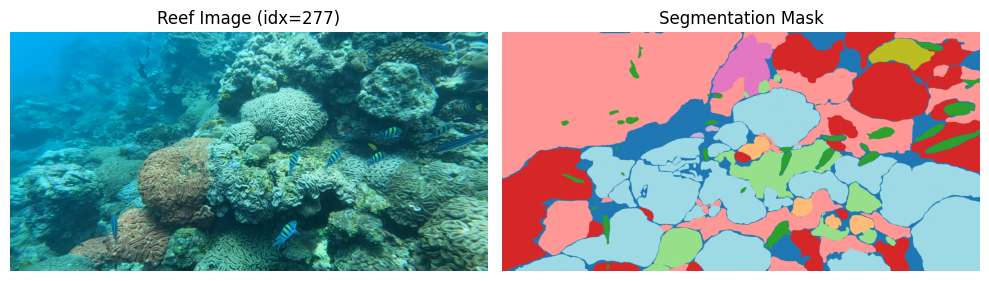

In [44]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.imshow(image_used)
plt.title(f"Reef Image (idx={rand_df_num})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_val, cmap="tab20")   # int-coded classes → colored for visualization
plt.title("Segmentation Mask")
plt.axis("off")
plt.tight_layout()
plt.show()

In [45]:
import numpy as np
from PIL import Image


ignore_index = None    # set to 255 if your masks use 255 as ignore

def compute_composition_and_health(mask, coral_ids=coral_ids,
                                   healthy_ids=healthy_ids, ignore_index=ignore_index):
    """
    mask: PIL.Image (L) or numpy array HxW of integer class IDs
    num_classes: total classes in dataset (e.g., 40)
    coral_ids: set of class IDs considered 'coral'
    healthy_ids: subset of coral_ids considered 'healthy'
    ignore_index: value to exclude (e.g., 255) or None
    """
    # Normalize input to numpy int array
    if isinstance(mask, Image.Image):
        mask = np.array(mask)
    else:
        mask = np.asarray(mask)
    mask = mask.astype(np.int64)

    # Optional: drop ignore pixels
    if ignore_index is not None:
        valid = (mask != ignore_index)
        flat = mask[valid].ravel()
    else:
        flat = mask.ravel()

    # Safety: if nothing valid, return empty composition and None health
    total_pixels = int(flat.size)
    if total_pixels == 0:
        return {}, None

    # Count pixels per class across the *dataset's full class space*
    counts = np.bincount(flat, minlength=40)

    # Build composition in the SAME raw format you used before
    composition = {
        cls: (int(counts[cls]), counts[cls] / max(1, total_pixels))
        for cls in range(40)
        if counts[cls] > 0
    }

    # Health score = healthy coral / all coral (None if no coral present)
    coral_count   = int(sum(counts[c] for c in coral_ids   if c < len(counts)))
    healthy_count = int(sum(counts[c] for c in healthy_ids if c < len(counts)))
    health_score = (healthy_count / coral_count) if coral_count > 0 else None

    return composition, health_score

act_comp,act_health = compute_composition_and_health(mask_val)
print(pretty_print_composition(act_comp))
print(health_score_processing(act_health))


Class (ID)                               |     Pixels | % of image
------------------------------------------------------------------
Bleached Silt (36)                       |    583,364 |     27.82%
Rubble (13)                              |    437,034 |     20.84%
Sponges (12)                             |    355,190 |     16.94%
Sand (14)                                |    245,010 |     11.68%
Background (0)                           |    225,978 |     10.78%
Turf Algae (10)                          |    107,505 |      5.13%
Macroalgae (9)                           |     52,729 |      2.51%
Bleached Acropora (23)                   |     39,917 |      1.90%
Dead Coral (6)                           |     23,107 |      1.10%
Bleached Rock (31)                       |     22,141 |      1.06%
Bleached Algae (37)                      |      3,020 |      0.14%
Water Column (17)                        |      2,157 |      0.10%
None
80.74


In [46]:
print("Predicted health score:",health_score_processed)
print("Actual health score:",health_score_processing(act_health))
intstep_error = health_score_processed-health_score_processing(act_health)
error = round((intstep_error/health_score_processing(act_health)) * 100,2)
print("Error:",error,"%")


Predicted health score: 90.73
Actual health score: 80.74
Error: 12.37 %


In [47]:

from collections import namedtuple
Result = namedtuple('Result', 'idx image pred_comp pred_health gt_comp gt_health error')

def sample_and_predict(idx=None):

    if idx is None:
        idx = random.randint(0, len(handydandy["test"]) - 1)
    
    row = handydandy["test"][idx]
    img = row["image"]
    mask = row['label']

    res = predict_image(
    img,
    model=model,
    num_classes=40,
    )

    pred_health = health_score_processing(res['health_score'])

    act_comp,act_health_raw = compute_composition_and_health(mask)

    act_health = health_score_processing(act_health_raw)

    if act_health is None or act_health == 0 or pred_health is None:
        error = None
    else:
        # intstep_error = pred_health - act_health           # both in percent
        # error = round((intstep_error / act_health) * 100, 2)

        error = round(pred_health - act_health,2)           # both in percent


    
    return Result(
        idx=idx,
        image=img,                  # PIL.Image or (H,W,3) uint8
        pred_comp=res['composition'],        # dict: {class_id/name: fraction or count}
        pred_health=float(pred_health),
        gt_comp=act_comp,            # same structure as pred_comp
        gt_health=float(act_health),
        error=error
    )

In [55]:
import numpy as np

def align_fraction_vectors(pred_comp: dict, gt_comp: dict, num_classes: int = 40):
    """Return two length-C vectors of fractions only (no counts). Missing classes -> 0."""
    p = np.zeros(num_classes, dtype=float)
    g = np.zeros(num_classes, dtype=float)
    for c in range(num_classes):
        if c in pred_comp:
            val = pred_comp[c]
            p[c] = float(val[1]) if isinstance(val, (list, tuple)) else float(val)
        if c in gt_comp:
            val = gt_comp[c]
            g[c] = float(val[1]) if isinstance(val, (list, tuple)) else float(val)
    return p, g

def composition_accuracy_fraction(pred_comp: dict, gt_comp: dict, num_classes: int = 40):
    """
    Accuracy over fractions only.
    = 1 - 0.5 * sum_i |p_i - g_i|  (a.k.a. 1 - total variation distance)
    """
    p, g = align_fraction_vectors(pred_comp, gt_comp, num_classes)
    return float(1.0 - 0.5 * np.abs(p - g).sum())


In [ ]:
# --- UI cell: ipywidgets without dropdown ---
import ipywidgets as w
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Controls
idx_text   = w.Text(value='', placeholder='leave blank for random', description='Index')
run_btn    = w.Button(description='New sample', button_style='info')
status_lbl = w.HTML(value='')
out        = w.Output(layout={'border': '1px solid #444', 'padding': '6px'})

def comp_to_df(comp_dict):
    """
    comp_dict format expected like:
        {class_id: (count, fraction_of_image), ...}
    Returns a DataFrame with columns: class, count, share_% (sorted by share_% desc).
    """
    if not comp_dict:
        return pd.DataFrame(columns=['class', 'count', 'share_%'])
    rows = []
    for cls, val in comp_dict.items():
        # accept (count, fraction) tuples or raw fractions
        if isinstance(val, (tuple, list)) and len(val) == 2:
            count, frac = val
        else:
            # heuristic: if it's just a number, treat as fraction with unknown count
            count, frac = (np.nan, float(val))
        rows.append((cls, int(count) if not pd.isna(count) else count, float(frac)))
    df = pd.DataFrame(rows, columns=['class', 'count', 'fraction'])
    df['share_%'] = (df['fraction'] * 100).round(2)
    df = df.drop(columns=['fraction']).sort_values('share_%', ascending=False).reset_index(drop=True)
    return df

# def render_result(result):
#     with out:
#         clear_output(wait=True)

#         # 0) Header summary
#         display(w.HTML(f"<h4 style='margin:4px 0'>Sample Index: {result.idx}</h4>"))
#         display(w.HTML(
#             f"<div>Predicted health: <b>{result.pred_health:.3f}</b> &nbsp;|&nbsp; "
#             f"Ground-truth health: <b>{result.gt_health:.3f}</b> &nbsp;|&nbsp; "
#             f"Error: <b>{result.error:.2f}</b></div>"
#         ))

#         # 1) Image
#         fig = plt.figure(figsize=(5,5))
#         img = result.image
#         if hasattr(img, 'mode'):  # PIL
#             plt.imshow(img)
#         else:
#             arr = img
#             if arr.ndim == 2:
#                 plt.imshow(arr, cmap='gray')
#             else:
#                 plt.imshow(arr)
#         plt.axis('off')
#         plt.title("Image")
#         plt.show()

#         # 2) Composition tables (Pred vs GT)
#         pred_df = comp_to_df(result.pred_comp)
#         gt_df   = comp_to_df(result.gt_comp)

#         display(w.HBox([
#             w.VBox([w.HTML("<b>Predicted composition</b>")]),
#             w.VBox([w.HTML("<b>Ground-truth composition</b>")]),
#         ]))
#         # Display DataFrames below the headers
#         display(w.HBox([
#             w.VBox([pred_df]),
#             w.VBox([gt_df]),
#         ]))

def fmt_pct(x):
    return "N/A" if x is None else f"{x:.2f}%"

def pretty_print_composition_to_output(comp_dict):
    out = w.Output()
    with out:
        print(f"{'Class (ID)':<40} | {'Pixels':>10} | {'% of image':>10}")
        print("-" * 66)
        if not comp_dict:
            print("(no classes present)")
        else:
            for cls, (count, frac) in sorted(comp_dict.items(), key=lambda x: -x[1][1]):
                label = CORALSCAPES_LABELS.get(int(cls), f"Unknown ({cls})")
                print(f"{label} ({cls})".ljust(40), f"| {count:>10,} | {float(frac)*100:>9.2f}%")
    return out

def render_result(result):
    with out:
        clear_output(wait=True)

        # 0) Header summary
        display(w.HTML(f"<h4 style='margin:4px 0'>Sample Index: {result.idx}</h4>"))

        display(w.HTML(f"<h3 style='margin:4px 0'>Material Analysis</h3>"))


        pred_out = pretty_print_composition_to_output(result.pred_comp)
        gt_out   = pretty_print_composition_to_output(result.gt_comp)

        display(
            w.HBox([
                w.VBox([w.HTML("<b>Predicted composition</b>"), pred_out],
                    layout=w.Layout(margin='0 20px 0 0')),
                w.VBox([w.HTML("<b>Ground-truth composition</b>"), gt_out]),
            ])
        )

        acc = float(composition_accuracy_fraction(result.pred_comp, result.gt_comp, num_classes=40) * 100)
        display(w.HTML(f"<h4 style='margin:4px 0'>Composition accuracy: {acc:.2f}%</h4>"))

        display(w.HTML(f" "))

        display(w.HTML(f"<h3 style='margin:4px 0'>Health Analysis</h3>"))

        display(w.HTML(
            f"<div>Predicted health: <b>{fmt_pct(result.pred_health)}</b> &nbsp;|&nbsp; "
            f"True health: <b>{fmt_pct(result.gt_health)}</b> &nbsp;|&nbsp; "
            f"Error (vs GT): <b>{result.error}</b></div>"
        ))


        # 1) Image
        fig = plt.figure(figsize=(5,5))
        img = result.image
        if hasattr(img, 'mode'):     # PIL.Image
            plt.imshow(img)
        else:                        # numpy
            arr = img
            if arr.ndim == 2:
                plt.imshow(arr, cmap='gray')
            else:
                plt.imshow(arr)
        plt.axis('off')
        plt.title("Image")
        plt.show()

        # 2) Composition tables (Pred vs GT)
        pred_df = comp_to_df(result.pred_comp)
        gt_df   = comp_to_df(result.gt_comp)

        # Use Output() widgets to display DataFrames (DataFrame itself is NOT a widget)
        # pred_out = w.Output()
        # gt_out   = w.Output()
        # with pred_out:
        #     display(pred_df)
        # with gt_out:
        #     display(gt_df)

        # # Titles + tables side by side, now as real widgets
        # display(
        #     w.HBox([
        #         w.VBox([w.HTML("<b>Predicted composition</b>"), pred_out],
        #                layout=w.Layout(margin='0 20px 0 0')),
        #         w.VBox([w.HTML("<b>True composition</b>"), gt_out]),
        #     ])
        # )
       
def on_click(_):
    run_btn.disabled = True
    status_lbl.value = "<i>Running…</i>"
    try:
        idx = None
        if idx_text.value.strip():
            idx = int(idx_text.value.strip())
        result = sample_and_predict(idx=idx)   # <- uses YOUR function
        render_result(result)
        status_lbl.value = ""
    except Exception as e:
        status_lbl.value = f"<span style='color:#c00'>Error: {e}</span>"
        raise
    finally:
        run_btn.disabled = False

run_btn.on_click(on_click)

ui = w.VBox([w.HBox([idx_text, run_btn]), status_lbl, out])
display(ui)
